<a href="https://colab.research.google.com/github/yohanesnuwara/nuwara-online-courses/blob/master/HPFEM_KTH/W1/HPFEM_W1_navier_stokes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from google.colab import files
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
    !mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
    !sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
    !mv temp /etc/apt/sources.list
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics    
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt
from IPython.display import clear_output, display, update_display
import time
import dolfin.common.plotting as fenicsplot 

E: Package 'python-software-properties' has no installation candidate
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ Packages [88.1 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic InRelease [15.4 kB]
Hit:11 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InReleas

## Code from EdX (not working)

In [0]:
%matplotlib inline
%run /home/fenics/fenics-matplotlib.py
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output; 
import time
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)

# Compact plot utility function
def plot_compact(u, t, stepcounter): 
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); 
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 2)
       
       	# Plot norm of velocity
        plt.subplot(1, 2, 1);
        fenicsplot.mplot_function(uEuclidnorm); 
        plt.title("Velocity")
        
        if t == 0.: 
           plt.colorbar(); 
           plt.axis(G)
        
        plt.subplot(1, 2, 2);
        
        if t == 0.:
           plt.triplot(mesh2triang(mesh)); 
           plt.title("Mesh") # Plot mesh
     	display(pl)

        plt.suptitle("Navier-Stokes t: %f" % (t));
        plt.tight_layout();
        clear_output(wait=True); 

############## Important code starts here ##############

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

mresolution=30
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

# FEM function spaces and functions
V = VectorFunctionSpace(mesh, "CG", 1); 
Q = FunctionSpace(mesh, "CG", 1);
W = V * Q; h = CellSize(mesh);
(v, q) = TestFunctions(W);
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX) 

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
nu = 1e-6; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = plt.subplots(); 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

print "elapsed CPU time: ", (time.clock() - timer0)  F

TabError: ignored

## After modification

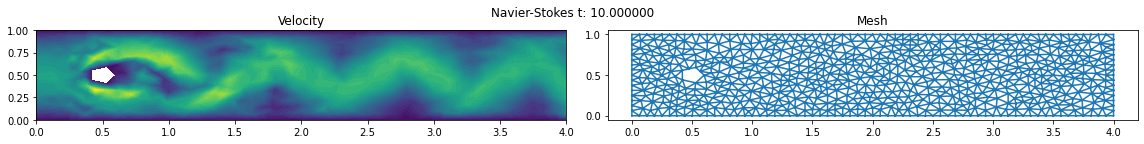

In [23]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output;
import time 
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)


# Compact plot utility function
def plot_compact(u, t, stepcounter): 
  if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); 
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 2)
       
       	# Plot norm of velocity
        ax1 = plt.subplot(1, 2, 1);
        fenicsplot.mplot_function(ax1, uEuclidnorm); 
        plt.title("Velocity")
        
        # if t == 0.: 
        #    plt.colorbar(); 
        #    plt.axis(G)
        
        plt.subplot(1, 2, 2);
        
        if t == 0.:
          plt.triplot(fenicsplot.mesh2triang(mesh)); 
          plt.title("Mesh") # Plot mesh

        display(pl)

        plt.suptitle("Navier-Stokes t: %f" % (t));
        plt.tight_layout();
        clear_output(wait=True); 


######## Important code starts here

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

"added degree???"
degree = 2

mresolution=30 
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

# FEM function spaces and functions
"modification by hateaf"
Ve = VectorElement("CG", mesh.ufl_cell(), 1)
Qe = FiniteElement("CG", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, Qe)
V = VectorFunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, Ve * Qe)

h = CellDiameter(mesh); 
(v, q) = TestFunctions(W); 
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, degree=degree)

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, degree=degree) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, degree=degree)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, degree=degree)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
nu = 1e-6; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = plt.subplots(); 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

# print ("elapsed CPU time: ", (time.clock() - timer0))

## Drag problem

0.10588303831892734


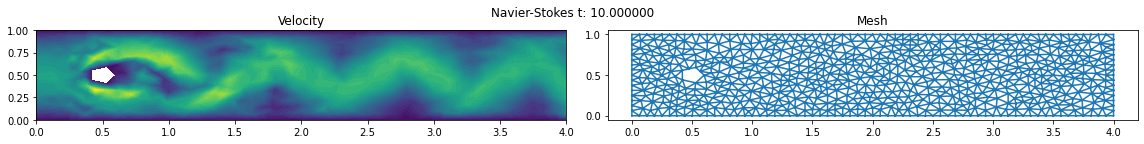

In [33]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output;
import time 
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)


# Compact plot utility function
def plot_compact(u, t, stepcounter): 
  if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); 
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 2)
       
       	# Plot norm of velocity
        ax1 = plt.subplot(1, 2, 1);
        fenicsplot.mplot_function(ax1, uEuclidnorm); 
        plt.title("Velocity")
        
        # if t == 0.: 
        #    plt.colorbar(); 
        #    plt.axis(G)
        
        plt.subplot(1, 2, 2);
        
        if t == 0.:
          plt.triplot(fenicsplot.mesh2triang(mesh)); 
          plt.title("Mesh") # Plot mesh

        display(pl)

        plt.suptitle("Navier-Stokes t: %f" % (t));
        plt.tight_layout();
        clear_output(wait=True); 


######## Important code starts here

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

"added degree???"
degree = 2

mresolution=30 
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

# FEM function spaces and functions
"modification by hateaf"
Ve = VectorElement("CG", mesh.ufl_cell(), 1)
Qe = FiniteElement("CG", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, Qe)
V = VectorFunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, Ve * Qe)

h = CellDiameter(mesh); 
(v, q) = TestFunctions(W); 
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, degree=degree)

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, degree=degree) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, degree=degree)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, degree=degree)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
nu = 1e-6; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = plt.subplots(); 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

# print ("elapsed CPU time: ", (time.clock() - timer0))

"Drag force computation"
n = FacetNormal(mesh)
# psimarker=Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2) + eps", XMIN=XMIN, XMAX=XMAX,YMIN=YMIN,YMAX=YMAX, eps=eps,degree=degree)
# psimarker=Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2)", XMIN=XMIN, XMAX=XMAX,YMIN=YMIN,YMAX=YMAX, eps=eps,degree=degree)
psimarker=Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2)", eps=eps,degree=degree)
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)
print(drag_force)

## Euler (exam)

0.10590091176022104


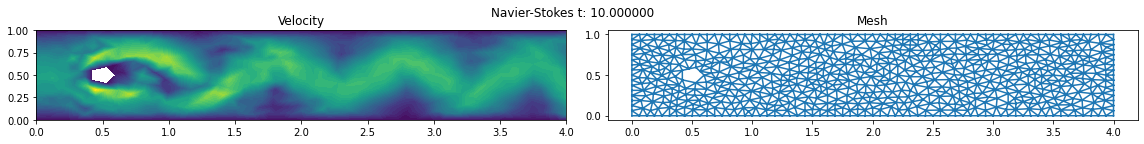

In [35]:
%matplotlib inline 
import matplotlib.pyplot as plt 
from dolfin import *; 
from mshr import *; 
from IPython.display import display, clear_output;
import time 
import logging; 
logging.getLogger('FFC').setLevel(logging.WARNING)


# Compact plot utility function
def plot_compact(u, t, stepcounter): 
  if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), Q); 
        ax.cla(); 
        fig = plt.gcf(); 
        fig.set_size_inches(16, 2)
       
       	# Plot norm of velocity
        ax1 = plt.subplot(1, 2, 1);
        fenicsplot.mplot_function(ax1, uEuclidnorm); 
        plt.title("Velocity")
        
        # if t == 0.: 
        #    plt.colorbar(); 
        #    plt.axis(G)
        
        plt.subplot(1, 2, 2);
        
        if t == 0.:
          plt.triplot(fenicsplot.mesh2triang(mesh)); 
          plt.title("Mesh") # Plot mesh

        display(pl)

        plt.suptitle("Navier-Stokes t: %f" % (t));
        plt.tight_layout();
        clear_output(wait=True); 


######## Important code starts here

# Generate domain and mesh
XMIN = 0.; 
XMAX = 4.; 
YMIN = 0; 
YMAX = 1.; 
G = [XMIN, XMAX, YMIN, YMAX]; 
eps = 1e-5

"added degree???"
degree = 2

mresolution=30 
mesh = generate_mesh(Rectangle(Point(G[0], G[2]), Point(G[1], G[3])) - Circle(Point(.5, .5), .1), mresolution)

# FEM function spaces and functions
"modification by hateaf"
Ve = VectorElement("CG", mesh.ufl_cell(), 1)
Qe = FiniteElement("CG", mesh.ufl_cell(), 1)
Q = FunctionSpace(mesh, Qe)
V = VectorFunctionSpace(mesh, "CG", 1)
W = FunctionSpace(mesh, Ve * Qe)

h = CellDiameter(mesh); 
(v, q) = TestFunctions(W); 
w = Function(W); 
(u, p) = (as_vector((w[0], w[1])), w[2]); 
u0 = Function(V)

# Inlet velocity
uin = Expression(("4*(x[1]*(YMAX-x[1]))/(YMAX*YMAX)", "0."), YMAX=YMAX, degree=degree)

# Mark regions for boundary conditions
om = Expression("x[0] > XMAX - eps ? 1. : 0.", XMAX=XMAX, eps=eps, degree=degree) 
im = Expression("x[0] < XMIN + eps ? 1. : 0.", XMIN=XMIN, eps=eps, degree=degree)
nm = Expression("x[0] > XMIN + eps && x[0] < XMAX - eps ? 1. : 0.", XMIN=XMIN, XMAX=XMAX, eps=eps, degree=degree)

# Timestep, viscosity and stabilization parameters
k = 0.1; 
nu = 1e-6; 
d = .2*h**(3./2.) 

# Time interval and penalty parameter
t, T = 0., 10.; 
gamma = 10*1./h 

pl, ax = plt.subplots(); 

# Initialize time stepping
stepcounter = 0; 
timer0 = time.clock()

# Time stepping method
theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler

# Time-stepping loop
while t < T: 
    # Weak residual of stabilized FEM for Navier-Stokes eq.
    um = theta*u + (1.0-theta)*u0
    
    # Navier-Stokes equations in weak residual form
    "Different in the formula"
    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + div(um)*q)*dx +
         gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
         d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
    
    # Solve the Navier-Stokes PDE (one timestep)
    solve(r==0, w)  

    # Visualize the solution
    plot_compact(u, t, stepcounter) # Plot all quantities (see implementation above)
    
    # Shift to next timestep
    t += k; 
    stepcounter += 1; 
    u0 = project(u, V); 

# print ("elapsed CPU time: ", (time.clock() - timer0))

"Drag force computation"
n = FacetNormal(mesh)
# psimarker=Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2) + eps", XMIN=XMIN, XMAX=XMAX,YMIN=YMIN,YMAX=YMAX, eps=eps,degree=degree)
# psimarker=Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2)", XMIN=XMIN, XMAX=XMAX,YMIN=YMIN,YMAX=YMAX, eps=eps,degree=degree)
psimarker=Expression("pow((x[0]-0.5),2) + pow((x[1]-0.5),2) < pow(0.1,2)", eps=eps,degree=degree)
M1 = psimarker*p*n[0]*ds # Drag (only pressure)
drag_force = assemble(M1)
print(drag_force)